# Forwards Player Analysis

Which forwards performed historically well over the last 3 seasons (2020/21 - 2022/23)? Well, it's complicated - players move around positions e.g. a player who was a forward and is now a midfielder such as Bryan Mbuemo. Obviously, the points earned by a player depend on their position - midfielders get 5 points for a goal whereas forwards get only 4. To overcome this, I will use 3 methods to rank the best 15 players from the last 3 seasons:

* **Method 1:** Take this season's forwards, and look at their average points over the last 3 seasons regardless of position. This is the "naive" method.
* **Method 2:** Take this season's forwards, and look at their average points over the last 3 seasons only if they also played as forwards in those seasons. This is the "strict forwards" approach.
* **Method 3:** Take this season's forwards, and map their stats over the last 3 seasons to the points they would've scored if they were a forward. This will require me to discard bonus points as these are scored differently per position and depend on the bps scored by all other players in the fixture. At this point, that is too complicated to account for.

I will then compare the top 15 forwards as measured by these methods (using their average total points - bonus points). Since we are discarding the bonus points, what matters here is the rank rather than the actual average points scored.

Once I have compared the players generated by these methods, I will select the best 15 forwards, and look at how their performance compares to this season so far (2023/24). I will carry out a one-sided t-test to see if there is a statistically significant difference in their performance, as well as look at the effect size to determine how big the difference is. I will then add information on their price this season, and the average rank of opposing teams. I will then export this information to an Excel file.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from statsmodels.stats.multitest import multipletests
from IPython.display import display_html
from IPython.display import HTML
from convert_points import convert_points

# Read and pre-process data

## 2023/24 data

In [2]:
path_2023_24 = '../data/Fantasy-Premier-League/data/2023-24/gws/merged_gw.csv'
data_2023_24 = pd.read_csv(path_2023_24, low_memory = False)
data_2023_24.loc[:,'total - bonus points'] = data_2023_24.total_points - data_2023_24.bonus
FWDs_2023_24 = data_2023_24.loc[data_2023_24.position == 'FWD', 'name'].unique()
data_2023_24

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,total - bonus points
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0.0,0,0,0,0,40,True,0,1,0
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,0.0,0,0,0,0,45,True,0,1,0
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,8.0,1,0,0,0,70,True,0,1,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0.0,0,0,0,0,40,True,0,1,0
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,17.0,2,0,0,0,55,True,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,Kyle Walker,DEF,Man City,5.0,0,0,14,0,5.5,369,...,4.0,2,245379,285979,40600,52,True,0,4,2
2637,Jacob Brown,FWD,Luton,1.2,0,0,2,0,0.0,631,...,2.0,1,-1785,625,2410,50,True,0,4,1
2638,Vicente Guaita,GK,Crystal Palace,0.0,0,0,0,0,0.0,227,...,0.0,0,-7875,660,8535,44,True,0,4,0
2639,Braian Ojeda Rodríguez,MID,Nott'm Forest,0.0,0,0,0,0,0.0,459,...,0.0,0,-44,0,44,45,False,0,4,0


## 2020/21 - 2022/23 data

In [3]:
data_2020_23_path = '../data/Fantasy-Premier-League/data/cleaned_merged_seasons.csv'
seasons_df = pd.read_csv(data_2020_23_path, low_memory = False)
seasons = ['2020-21', '2021-22', '2022-23']
data_2020_23_df = seasons_df.loc[seasons_df.season_x.isin(seasons),:]
data_2020_23_df.position = data_2020_23_df.position.map({'DEF':'DEF','FWD':'FWD','GK':'GK','GKP':'GK','MID':'MID'})
FWDs_2020_23_data = data_2020_23_df.loc[data_2020_23_df.name.isin(FWDs_2023_24),:]
FWDs_2020_23_data.loc[:,'total - bonus points'] = FWDs_2020_23_data.total_points - FWDs_2020_23_data.bonus
FWDs_2020_23_data

C:\Users\Andrew\AppData\Local\Temp\ipykernel_10520\2913249710.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020_23_df.position = data_2020_23_df.position.map({'DEF':'DEF','FWD':'FWD','GK':'GK','GKP':'GK','MID':'MID'})
C:\Users\Andrew\AppData\Local\Temp\ipykernel_10520\2913249710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FWDs_2020_23_data.loc[:,'total - bonus points'] = FWDs_2020_23_data.total_points - FWDs_2020_23_data.bonus


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,total - bonus points
19852,2020-21,Aaron Connolly,FWD,Brighton,0,0,-3,0,0.3,78,...,32.0,1,0,0,0,55,True,0,1,1
19867,2020-21,Aleksandar Mitrović,FWD,Fulham,0,0,3,0,0.3,184,...,7.0,1,0,0,0,60,True,0,1,1
19912,2020-21,Callum Wilson,FWD,Newcastle,0,2,32,1,23.3,506,...,50.0,8,0,0,0,65,False,0,1,6
19938,2020-21,Danny Ings,FWD,Southampton,0,0,1,0,11.2,366,...,60.0,2,0,0,0,85,False,0,1,2
19958,2020-21,Dominic Calvert-Lewin,FWD,Everton,0,2,34,1,13.7,164,...,34.0,8,0,0,0,70,False,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96106,2022-23,Danny Ings,FWD,West Ham,1,0,3,0,0.0,30,...,0.0,3,1118,4009,2891,63,False,1,38,3
96115,2022-23,Odsonne Edouard,FWD,Crystal Palace,0,0,4,0,0.0,166,...,0.0,2,12844,18089,5245,50,True,0,38,2
96123,2022-23,Deniz Undav,FWD,Brighton,0,0,23,0,0.0,123,...,0.0,5,-13569,4263,17832,50,False,1,38,5
96134,2022-23,Jhon Durán,FWD,Aston Villa,0,0,0,0,0.0,711,...,0.0,0,-126,174,300,55,True,0,38,0


# Method 1 (Naive)

Look at this season's forwards' historical performance over the last 3 years (2020/21 - 2022/23), regardless of the position they played in those seasons. This is the "naive" approach.

## Which players had the highest median score from 2020/21 - 2022/23?

As seen in the points distributions per position plots, the total points scored by forwards have a right skew. Outliers can inflate the mean compared to the median which is more robust.

In [4]:
top_15_FWDs_med = FWDs_2020_23_data.loc[:,['name','total_points', 'total - bonus points']].groupby(['name']).median()
top_15_FWDs_med.sort_values(by = 'total - bonus points', ascending = False, inplace = True)
top_15_FWDs_med = top_15_FWDs_med.iloc[0:15,:]
top_15_FWDs_med

,total_points,total - bonus points
name,,
Erling Haaland,6.0,6.0
Harry Kane,6.0,5.0
Cody Gakpo,2.5,2.5
Chris Wood,2.0,2.0
Ivan Toney,2.0,2.0
Dominic Solanke,2.0,2.0
Danny Ings,2.0,2.0
Gabriel Fernando de Jesus,2.0,2.0
Michail Antonio,2.0,2.0


So it turns out the median is a fairly useless metric, besides showing that Haaland and Kane are practically in a league of their own.

## Which players had the highest mean score from 2020/21 - 2022/23?

In [5]:
top_15_FWDs_mean = FWDs_2020_23_data.loc[:,['name','total_points', 'total - bonus points']].groupby(['name']).mean()
top_15_FWDs_mean.sort_values(by = 'total - bonus points', ascending = False, inplace = True)
top_15_FWDs_mean = top_15_FWDs_mean.iloc[0:15,:]
top_15_FWDs_mean

,total_points,total - bonus points
name,,
Erling Haaland,7.157895,6.105263
Harry Kane,6.114035,5.140351
Cody Gakpo,4.090909,3.909091
Ollie Watkins,4.157895,3.631579
Ivan Toney,4.223684,3.513158
Dominic Solanke,3.421053,3.052632
Daniel Jebbison,3.000000,2.750000
Gabriel Fernando de Jesus,3.157895,2.728070
Callum Wilson,3.210526,2.719298


In [6]:
top_15_FWD_names = list(top_15_FWDs_mean.index)
top_15_FWD_names

['Erling Haaland',
 'Harry Kane',
 'Cody Gakpo',
 'Ollie Watkins',
 'Ivan Toney',
 'Dominic Solanke',
 'Daniel Jebbison',
 'Gabriel Fernando de Jesus',
 'Callum Wilson',
 'Michail Antonio',
 'Danny Ings',
 'Yoane Wissa',
 'Darwin Núñez Ribeiro',
 'Alexander Isak',
 'Julián Álvarez']

##  How many matches did these players play?

In [7]:
matches_played = FWDs_2020_23_data.loc[:,['name','GW']].groupby('name').size()
matches_played = matches_played.loc[top_15_FWD_names]
matches_played.name = 'GWs played'
top_15_FWDs_mean = top_15_FWDs_mean.join(matches_played)
top_15_FWDs_mean

,total_points,total - bonus points,GWs played
name,,,
Erling Haaland,7.157895,6.105263,38
Harry Kane,6.114035,5.140351,114
Cody Gakpo,4.090909,3.909091,22
Ollie Watkins,4.157895,3.631579,114
Ivan Toney,4.223684,3.513158,76
Dominic Solanke,3.421053,3.052632,38
Daniel Jebbison,3.000000,2.750000,4
Gabriel Fernando de Jesus,3.157895,2.728070,114
Callum Wilson,3.210526,2.719298,114


## Extract points data for each of these players and generate boxplots:

In [8]:
points_data = []
for name in top_15_FWD_names:
    points_data.append(FWDs_2020_23_data.loc[FWDs_2020_23_data.name == name,'total - bonus points'].values.astype(float))

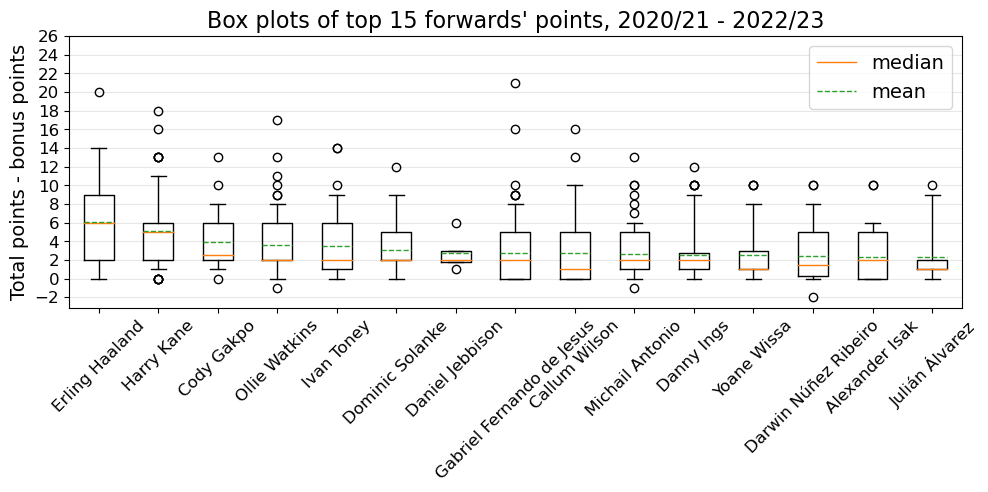

In [9]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 12

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
box_dict = ax.boxplot(points_data, whis=(5,95), labels = top_15_FWD_names, meanline = True, showmeans = True)
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize = axis_tick_font, rotation = 45)
_ = ax.set_yticks(np.arange(-2,28,2))
_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize = axis_tick_font)
ax.set_ylabel('Total points - bonus points', fontsize = axis_label_font)
ax.grid(axis = 'y', alpha = 0.3)
ax.legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax.set_title('''Box plots of top 15 forwards' points, 2020/21 - 2022/23''', fontsize = axis_title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/top_15_FWDs_boxplots.png', bbox_inches = 'tight')
plt.show()

## Method 1 Summary Results

We won't look at how these points are scored yet, because again that depends on position.
So, overall, the best 15 players ranked by their total - bonus points irrespective of position is:

In [10]:
method_1_results = top_15_FWDs_mean.copy()
method_1_results

,total_points,total - bonus points,GWs played
name,,,
Erling Haaland,7.157895,6.105263,38
Harry Kane,6.114035,5.140351,114
Cody Gakpo,4.090909,3.909091,22
Ollie Watkins,4.157895,3.631579,114
Ivan Toney,4.223684,3.513158,76
Dominic Solanke,3.421053,3.052632,38
Daniel Jebbison,3.000000,2.750000,4
Gabriel Fernando de Jesus,3.157895,2.728070,114
Callum Wilson,3.210526,2.719298,114


# Method 2 (Strict Forwards)

Select only players that are forwards this season and played as forwards in the last 3 seasons.

In [11]:
strict_FWDs = FWDs_2020_23_data.loc[FWDs_2020_23_data.position == 'FWD', :]
strict_FWDs

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,total - bonus points
19852,2020-21,Aaron Connolly,FWD,Brighton,0,0,-3,0,0.3,78,...,32.0,1,0,0,0,55,True,0,1,1
19867,2020-21,Aleksandar Mitrović,FWD,Fulham,0,0,3,0,0.3,184,...,7.0,1,0,0,0,60,True,0,1,1
19912,2020-21,Callum Wilson,FWD,Newcastle,0,2,32,1,23.3,506,...,50.0,8,0,0,0,65,False,0,1,6
19938,2020-21,Danny Ings,FWD,Southampton,0,0,1,0,11.2,366,...,60.0,2,0,0,0,85,False,0,1,2
19958,2020-21,Dominic Calvert-Lewin,FWD,Everton,0,2,34,1,13.7,164,...,34.0,8,0,0,0,70,False,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96106,2022-23,Danny Ings,FWD,West Ham,1,0,3,0,0.0,30,...,0.0,3,1118,4009,2891,63,False,1,38,3
96115,2022-23,Odsonne Edouard,FWD,Crystal Palace,0,0,4,0,0.0,166,...,0.0,2,12844,18089,5245,50,True,0,38,2
96123,2022-23,Deniz Undav,FWD,Brighton,0,0,23,0,0.0,123,...,0.0,5,-13569,4263,17832,50,False,1,38,5
96134,2022-23,Jhon Durán,FWD,Aston Villa,0,0,0,0,0.0,711,...,0.0,0,-126,174,300,55,True,0,38,0


## Which players had the highest mean score from 2020/21 to 2022/23?

In [12]:
top_15_FWDs_mean = strict_FWDs.loc[:,['name','total_points', 'total - bonus points']].groupby(['name']).mean()
top_15_FWDs_mean.sort_values(by = 'total - bonus points', ascending = False, inplace = True)
top_15_FWDs_mean = top_15_FWDs_mean.iloc[0:15,:]
top_15_FWDs_mean

,total_points,total - bonus points
name,,
Erling Haaland,7.157895,6.105263
Harry Kane,6.114035,5.140351
Ollie Watkins,4.157895,3.631579
Ivan Toney,4.223684,3.513158
Dominic Solanke,3.421053,3.052632
Daniel Jebbison,3.000000,2.750000
Gabriel Fernando de Jesus,3.157895,2.728070
Callum Wilson,3.210526,2.719298
Michail Antonio,3.000000,2.675439


In [13]:
top_15_FWD_names = list(top_15_FWDs_mean.index)
top_15_FWD_names

['Erling Haaland',
 'Harry Kane',
 'Ollie Watkins',
 'Ivan Toney',
 'Dominic Solanke',
 'Daniel Jebbison',
 'Gabriel Fernando de Jesus',
 'Callum Wilson',
 'Michail Antonio',
 'Danny Ings',
 'Darwin Núñez Ribeiro',
 'Alexander Isak',
 'Julián Álvarez',
 'Chris Wood',
 'Taiwo Awoniyi']

## How many GWs did they play?

In [14]:
matches_played = strict_FWDs.loc[:,['name','GW']].groupby('name').size()
matches_played = matches_played.loc[top_15_FWD_names]
matches_played.name = 'GWs played'
top_15_FWDs_mean = top_15_FWDs_mean.join(matches_played)
top_15_FWDs_mean

,total_points,total - bonus points,GWs played
name,,,
Erling Haaland,7.157895,6.105263,38
Harry Kane,6.114035,5.140351,114
Ollie Watkins,4.157895,3.631579,114
Ivan Toney,4.223684,3.513158,76
Dominic Solanke,3.421053,3.052632,38
Daniel Jebbison,3.000000,2.750000,4
Gabriel Fernando de Jesus,3.157895,2.728070,114
Callum Wilson,3.210526,2.719298,114
Michail Antonio,3.000000,2.675439,114


## Method 2 Summary Results

In [15]:
method_2_results = top_15_FWDs_mean.copy()
method_2_results

,total_points,total - bonus points,GWs played
name,,,
Erling Haaland,7.157895,6.105263,38
Harry Kane,6.114035,5.140351,114
Ollie Watkins,4.157895,3.631579,114
Ivan Toney,4.223684,3.513158,76
Dominic Solanke,3.421053,3.052632,38
Daniel Jebbison,3.000000,2.750000,4
Gabriel Fernando de Jesus,3.157895,2.728070,114
Callum Wilson,3.210526,2.719298,114
Michail Antonio,3.000000,2.675439,114


# Method 3 (Points map)

Map the stats from all of this season's forwards from 2020 - 2023 to the points they would've scored if they were a forward. Sum across the columns to get total - bonus points.

## Re-map the points

In [16]:
Remap_FWDs_2020_2023 = FWDs_2020_23_data.loc[:, ['name', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'saves',
                          'penalties_saved', 'penalties_missed', 'goals_conceded', 'yellow_cards',
                          'red_cards', 'own_goals']]
Remap_FWDs_2020_2023 = convert_points('FWD', Remap_FWDs_2020_2023)
Remap_FWDs_2020_2023['total - bonus points'] =  Remap_FWDs_2020_2023.drop(columns=['name']).sum(axis=1)
Remap_FWDs_2020_2023

,name,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,penalties_missed,goals_conceded,yellow_cards,red_cards,own_goals,total - bonus points
19852,Aaron Connolly,1,0,0,0,0,0,0,0,0,0,0,1
19867,Aleksandar Mitrović,1,0,0,0,0,0,0,0,0,0,0,1
19912,Callum Wilson,2,4,0,0,0,0,0,0,0,0,0,6
19938,Danny Ings,2,0,0,0,0,0,0,0,0,0,0,2
19958,Dominic Calvert-Lewin,2,4,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96106,Danny Ings,1,0,3,0,0,0,0,0,-1,0,0,3
96115,Odsonne Edouard,2,0,0,0,0,0,0,0,0,0,0,2
96123,Deniz Undav,2,4,0,0,0,0,0,0,-1,0,0,5
96134,Jhon Durán,0,0,0,0,0,0,0,0,0,0,0,0


## Which players had the highest mean points after the remapping?

In [17]:
top_15_FWDs_mean = Remap_FWDs_2020_2023.loc[:,['name','total - bonus points']].groupby(['name']).mean()
top_15_FWDs_mean.sort_values(by = 'total - bonus points', ascending = False, inplace = True)
top_15_FWDs_mean = top_15_FWDs_mean.iloc[0:15,:]
top_15_FWDs_mean

,total - bonus points
name,
Erling Haaland,6.105263
Harry Kane,5.140351
Ollie Watkins,3.631579
Ivan Toney,3.513158
Cody Gakpo,3.318182
Dominic Solanke,3.052632
Daniel Jebbison,2.750000
Gabriel Fernando de Jesus,2.728070
Callum Wilson,2.719298


In [18]:
top_15_FWD_names = list(top_15_FWDs_mean.index)
top_15_FWD_names

['Erling Haaland',
 'Harry Kane',
 'Ollie Watkins',
 'Ivan Toney',
 'Cody Gakpo',
 'Dominic Solanke',
 'Daniel Jebbison',
 'Gabriel Fernando de Jesus',
 'Callum Wilson',
 'Michail Antonio',
 'Danny Ings',
 'Darwin Núñez Ribeiro',
 'Alexander Isak',
 'Julián Álvarez',
 'Chris Wood']

## How many games did they play?

In [19]:
matches_played = FWDs_2020_23_data.loc[:,['name','GW']].groupby('name').size()
matches_played = matches_played.loc[top_15_FWD_names]
matches_played.name = 'GWs played'
top_15_FWDs_mean = top_15_FWDs_mean.join(matches_played)
top_15_FWDs_mean

,total - bonus points,GWs played
name,,
Erling Haaland,6.105263,38
Harry Kane,5.140351,114
Ollie Watkins,3.631579,114
Ivan Toney,3.513158,76
Cody Gakpo,3.318182,22
Dominic Solanke,3.052632,38
Daniel Jebbison,2.750000,4
Gabriel Fernando de Jesus,2.728070,114
Callum Wilson,2.719298,114


## Method 3 Summary Results

In [20]:
method_3_results = top_15_FWDs_mean.copy()
method_3_results

,total - bonus points,GWs played
name,,
Erling Haaland,6.105263,38
Harry Kane,5.140351,114
Ollie Watkins,3.631579,114
Ivan Toney,3.513158,76
Cody Gakpo,3.318182,22
Dominic Solanke,3.052632,38
Daniel Jebbison,2.750000,4
Gabriel Fernando de Jesus,2.728070,114
Callum Wilson,2.719298,114


# How do the results from the 3 methods compare?

In [21]:
# Set up HTML styles to display tables side-by-side
method_1_results = method_1_results.drop(columns=['total_points'])
method_2_results = method_2_results.drop(columns=['total_points'])
styles = [dict(selector="caption",props=[("font-size", "175%")])]
method_1_styler = method_1_results.style.set_table_attributes("style='display:inline'").set_caption('Method 1 (Naive)').set_table_styles(styles)
method_2_styler = method_2_results.style.set_table_attributes("style='display:inline'").set_caption('Method 2 (Strict FWDs)').set_table_styles(styles)
method_3_styler = method_3_results.style.set_table_attributes("style='display:inline'").set_caption('Method 3 (Remap pts)').set_table_styles(styles)
display_html(method_1_styler._repr_html_()+method_2_styler._repr_html_()+method_3_styler._repr_html_(), raw=True)

,total - bonus points,GWs played
name,,
Erling Haaland,6.105263,38
Harry Kane,5.140351,114
Cody Gakpo,3.909091,22
Ollie Watkins,3.631579,114
Ivan Toney,3.513158,76
Dominic Solanke,3.052632,38
Daniel Jebbison,2.750000,4
Gabriel Fernando de Jesus,2.728070,114
Callum Wilson,2.719298,114


Overall, there is a large amount of overlap between the 3 methods. Of note, the following players that ranked highly in Method 1 (highest mean score regardless of position played) that were then dropped after the points remap were:
* Yoane Wissa (replaced By Chris Wood)

As Chris Wood also appears in Method 2 (i.e. he was actually playing as a Forward), I am happy to take the 15 players as ranked by Method 3 and continue the analysis.

In [22]:
top_15_FWDs = list(method_3_results.index)
top_15_FWDs

['Erling Haaland',
 'Harry Kane',
 'Ollie Watkins',
 'Ivan Toney',
 'Cody Gakpo',
 'Dominic Solanke',
 'Daniel Jebbison',
 'Gabriel Fernando de Jesus',
 'Callum Wilson',
 'Michail Antonio',
 'Danny Ings',
 'Darwin Núñez Ribeiro',
 'Alexander Isak',
 'Julián Álvarez',
 'Chris Wood']

# What's their performance like this season so far?

## Preprocessing before analysis:

First let's rename and reorder columns, then calculate standard deviation of total - bonus points.

In [23]:
method_3_results.rename(columns={'total - bonus points':'mean total - bonus 2020 - 2023','GWs played': 'GWs played 2020-2023'}, inplace = True)
method_3_results = method_3_results[['GWs played 2020-2023', 'mean total - bonus 2020 - 2023']]
# Standard deviation of remapped points:
pts_std = Remap_FWDs_2020_2023.loc[:,['name','total - bonus points']].groupby(['name']).std()
pts_std.rename(columns = {'total - bonus points':'Std total - bonus 2020 - 2023'},inplace = True)
method_3_results = method_3_results.join(pts_std, how='left')
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023
name,,,
Erling Haaland,38,6.105263,4.554709
Harry Kane,114,5.140351,3.594187
Ollie Watkins,114,3.631579,2.851061
Ivan Toney,76,3.513158,3.259830
Cody Gakpo,22,3.318182,2.834924
Dominic Solanke,38,3.052632,2.846974
Daniel Jebbison,4,2.750000,2.217356
Gabriel Fernando de Jesus,114,2.728070,3.316051
Callum Wilson,114,2.719298,3.374839


## Join 2023/24 season data:

In [24]:
mean_pts_2023_24 = data_2023_24.loc[data_2023_24.name.isin(top_15_FWDs),['name','total - bonus points']].groupby(['name']).mean()
mean_pts_2023_24.rename(columns={'total - bonus points':'mean total - bonus 2023-24'}, inplace = True)
method_3_results = method_3_results.join(mean_pts_2023_24, how = 'left')
method_3_results.drop(labels=['Harry Kane', 'Ivan Toney'], inplace = True)
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24
name,,,,
Erling Haaland,38,6.105263,4.554709,8.25
Ollie Watkins,114,3.631579,2.851061,4.25
Cody Gakpo,22,3.318182,2.834924,1.50
Dominic Solanke,38,3.052632,2.846974,4.75
Daniel Jebbison,4,2.750000,2.217356,0.00
Gabriel Fernando de Jesus,114,2.728070,3.316051,1.25
Callum Wilson,114,2.719298,3.374839,3.00
Michail Antonio,114,2.675439,2.564204,3.75
Danny Ings,114,2.526316,2.720654,0.75


## Statistical Test

We want to see if there's a statistically significant difference in the performance of these players this season (so far). That is, we want to say with a 95% confidence that there is an effect present in the data causing the change in performance. We cannot say what this effect is - i.e. is it because these players have played a sequence of easy or hard teams so far? Are they playing out of position? We can only say that an effect exists, and we will factor this into our eventual drafting decisions.

To this end:
* We will calculate the effect size - this shows how large the deviation in performance is this season compared to the last 3 seasons.
* We will carry out a 1-sided t-test for the mean total - bonus points. We consider the 3 previous seasons from 2020/21 - 2022/23 to be our population data: we have all the data from these seasons, not just a sample of a handful of games. We will compare this to our "sample" this season: the GWs that have been played so far. A 1-sided test will be used because we care about the "direction" of the change, i.e. we care not just that it changed, but did it increase or decrease?
* We will then use the Benjamini-Hochberg procedure to limit the False Discovery Rate (FDR) to 5% - as we are carrying out ~15 tests, we want to be sure we're not measuring an effect due to sampling chance.

### Effect Size

We will use Cohen's d to measure effect size.

In [25]:
method_3_results['Effect size'] = (method_3_results['mean total - bonus 2023-24'] - \
                                   method_3_results['mean total - bonus 2020 - 2023'])\
                                    /method_3_results['Std total - bonus 2020 - 2023']
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size
name,,,,,
Erling Haaland,38,6.105263,4.554709,8.25,0.470883
Ollie Watkins,114,3.631579,2.851061,4.25,0.216909
Cody Gakpo,22,3.318182,2.834924,1.50,-0.641351
Dominic Solanke,38,3.052632,2.846974,4.75,0.596201
Daniel Jebbison,4,2.750000,2.217356,0.00,-1.240216
Gabriel Fernando de Jesus,114,2.728070,3.316051,1.25,-0.445732
Callum Wilson,114,2.719298,3.374839,3.00,0.083175
Michail Antonio,114,2.675439,2.564204,3.75,0.419062
Danny Ings,114,2.526316,2.720654,0.75,-0.652900


### 1-sided t-test

$H_0$ $:$ mean points 2023/24 season - mean points 2020/21 - 2022/23 = 0

$H_A$ $:$ mean points 2023/24 season > mean points 2020/21 - 2022/23 **OR** mean points 2023/24 season < mean points 2020/21 - 2022/23
(depending on the change)

In [26]:
method_3_results['n'] = len(data_2023_24['GW'].unique()) # Sample size
method_3_results['SE'] = method_3_results['Std total - bonus 2020 - 2023']/np.sqrt(method_3_results['n'])
method_3_results['t'] = (method_3_results['mean total - bonus 2023-24'] - \
                        method_3_results['mean total - bonus 2020 - 2023'])/method_3_results['SE']
method_3_results['p-value'] = t.sf(np.abs(method_3_results['t'].values), method_3_results['n'].values-1)
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value
name,,,,,,,,,
Erling Haaland,38,6.105263,4.554709,8.25,0.470883,4,2.277355,0.941767,0.207895
Ollie Watkins,114,3.631579,2.851061,4.25,0.216909,4,1.425531,0.433818,0.346862
Cody Gakpo,22,3.318182,2.834924,1.50,-0.641351,4,1.417462,-1.282702,0.144860
Dominic Solanke,38,3.052632,2.846974,4.75,0.596201,4,1.423487,1.192402,0.159411
Daniel Jebbison,4,2.750000,2.217356,0.00,-1.240216,4,1.108678,-2.480432,0.044618
Gabriel Fernando de Jesus,114,2.728070,3.316051,1.25,-0.445732,4,1.658026,-0.891464,0.219179
Callum Wilson,114,2.719298,3.374839,3.00,0.083175,4,1.687419,0.166350,0.439231
Michail Antonio,114,2.675439,2.564204,3.75,0.419062,4,1.282102,0.838125,0.231740
Danny Ings,114,2.526316,2.720654,0.75,-0.652900,4,1.360327,-1.305801,0.141364


### Benjamini-Hochberg Procedure

Control the false discovery rate (FDR) to 5%. We will not record the new p-values - just whether the null hypothesis is rejected or not i.e. whether the result is statistically significant.

In [27]:
method_3_results['BH Statistically Significant'], _, _, _ = multipletests(method_3_results['p-value'].values, 
                                                                alpha=0.05, 
                                                                method='fdr_bh',
                                                                is_sorted=False, 
                                                                returnsorted=False)
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value,BH Statistically Significant
name,,,,,,,,,,
Erling Haaland,38,6.105263,4.554709,8.25,0.470883,4,2.277355,0.941767,0.207895,False
Ollie Watkins,114,3.631579,2.851061,4.25,0.216909,4,1.425531,0.433818,0.346862,False
Cody Gakpo,22,3.318182,2.834924,1.50,-0.641351,4,1.417462,-1.282702,0.144860,False
Dominic Solanke,38,3.052632,2.846974,4.75,0.596201,4,1.423487,1.192402,0.159411,False
Daniel Jebbison,4,2.750000,2.217356,0.00,-1.240216,4,1.108678,-2.480432,0.044618,False
Gabriel Fernando de Jesus,114,2.728070,3.316051,1.25,-0.445732,4,1.658026,-0.891464,0.219179,False
Callum Wilson,114,2.719298,3.374839,3.00,0.083175,4,1.687419,0.166350,0.439231,False
Michail Antonio,114,2.675439,2.564204,3.75,0.419062,4,1.282102,0.838125,0.231740,False
Danny Ings,114,2.526316,2.720654,0.75,-0.652900,4,1.360327,-1.305801,0.141364,False


### Effect Size Label:

In [28]:
method_3_results['Effect size label'] = np.digitize(np.abs(method_3_results['Effect size']), [0.01,0.2,0.5,0.8,1.20,2.0],
                                                   right = True)
method_3_results['Effect size label'] = method_3_results['Effect size label'].map({0:'None',1:'Very small',2:'Small',
                                                                                   3:'Medium',4:'Large',5:'Very large',
                                                                                   6:'Huge'})
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value,BH Statistically Significant,Effect size label
name,,,,,,,,,,,
Erling Haaland,38,6.105263,4.554709,8.25,0.470883,4,2.277355,0.941767,0.207895,False,Small
Ollie Watkins,114,3.631579,2.851061,4.25,0.216909,4,1.425531,0.433818,0.346862,False,Small
Cody Gakpo,22,3.318182,2.834924,1.50,-0.641351,4,1.417462,-1.282702,0.144860,False,Medium
Dominic Solanke,38,3.052632,2.846974,4.75,0.596201,4,1.423487,1.192402,0.159411,False,Medium
Daniel Jebbison,4,2.750000,2.217356,0.00,-1.240216,4,1.108678,-2.480432,0.044618,False,Very large
Gabriel Fernando de Jesus,114,2.728070,3.316051,1.25,-0.445732,4,1.658026,-0.891464,0.219179,False,Small
Callum Wilson,114,2.719298,3.374839,3.00,0.083175,4,1.687419,0.166350,0.439231,False,Very small
Michail Antonio,114,2.675439,2.564204,3.75,0.419062,4,1.282102,0.838125,0.231740,False,Small
Danny Ings,114,2.526316,2.720654,0.75,-0.652900,4,1.360327,-1.305801,0.141364,False,Medium


### Statistical Test Conclusion

We fail to reject the null hypothesis $H_0$ for all 15 players after applying the Benjamini Hochberg procedure, meaning the performance deviation of these players is not statistically significant. It may be the case for some players that their performance actually hasn't changed at all, whereas for others, it may be due to chance in the sample of games they've played so far.

# Additional Stats for 2023/24 season

Price, and average rank of opponent teams so far are important metrics to analyse when drafting players.

## Add price column

In [29]:
latest_GW = data_2023_24.GW.max()
current_price_df = data_2023_24.loc[(data_2023_24.GW == latest_GW) & (data_2023_24.name.isin(top_15_FWDs)), 
                                    ['name','value']]
current_price_df.set_index('name',inplace=True)
current_price_df.value /= 10 # get price in millions
current_price_df.rename(columns={'value':'Current Price (M)'}, inplace=True)
method_3_results = method_3_results.join(current_price_df, how='left')
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value,BH Statistically Significant,Effect size label,Current Price (M)
name,,,,,,,,,,,,
Erling Haaland,38,6.105263,4.554709,8.25,0.470883,4,2.277355,0.941767,0.207895,False,Small,14.0
Ollie Watkins,114,3.631579,2.851061,4.25,0.216909,4,1.425531,0.433818,0.346862,False,Small,8.0
Cody Gakpo,22,3.318182,2.834924,1.50,-0.641351,4,1.417462,-1.282702,0.144860,False,Medium,7.4
Dominic Solanke,38,3.052632,2.846974,4.75,0.596201,4,1.423487,1.192402,0.159411,False,Medium,6.5
Daniel Jebbison,4,2.750000,2.217356,0.00,-1.240216,4,1.108678,-2.480432,0.044618,False,Very large,4.9
Gabriel Fernando de Jesus,114,2.728070,3.316051,1.25,-0.445732,4,1.658026,-0.891464,0.219179,False,Small,7.9
Callum Wilson,114,2.719298,3.374839,3.00,0.083175,4,1.687419,0.166350,0.439231,False,Very small,7.9
Michail Antonio,114,2.675439,2.564204,3.75,0.419062,4,1.282102,0.838125,0.231740,False,Small,6.1
Danny Ings,114,2.526316,2.720654,0.75,-0.652900,4,1.360327,-1.305801,0.141364,False,Medium,5.9


## Add mean opposition strength column

In [30]:
team_data_path = '../data/Fantasy-Premier-League/data/2023-24/teams.csv'
team_data = pd.read_csv(team_data_path)
team_id_rank_map = dict(zip(team_data.id, team_data.strength)) # Create map between team id and strength

In [31]:
avg_team_rank = data_2023_24.loc[data_2023_24.name.isin(top_15_FWDs), ['name','opponent_team']]
avg_team_rank.opponent_team = avg_team_rank.opponent_team.map(team_id_rank_map)
avg_team_rank = avg_team_rank.groupby('name').mean()
avg_team_rank.rename(columns = {'opponent_team': 'Average opposition strength 2023/24'}, inplace=True)
method_3_results = method_3_results.join(avg_team_rank, how='left')
method_3_results.rename(columns = {'n': 'GWs played 2023-24'}, inplace=True)
method_3_results = method_3_results[['GWs played 2020-2023','mean total - bonus 2020 - 2023',
                                     'Std total - bonus 2020 - 2023',
                                     'GWs played 2023-24','mean total - bonus 2023-24',
                                     'Effect size',
                                     'SE','t','p-value','BH Statistically Significant',
                                     'Effect size label','Current Price (M)','Average opposition strength 2023/24']]
method_3_results

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,GWs played 2023-24,mean total - bonus 2023-24,Effect size,SE,t,p-value,BH Statistically Significant,Effect size label,Current Price (M),Average opposition strength 2023/24
name,,,,,,,,,,,,,
Erling Haaland,38,6.105263,4.554709,4,8.25,0.470883,2.277355,0.941767,0.207895,False,Small,14.0,2.75
Ollie Watkins,114,3.631579,2.851061,4,4.25,0.216909,1.425531,0.433818,0.346862,False,Small,8.0,3.25
Cody Gakpo,22,3.318182,2.834924,4,1.50,-0.641351,1.417462,-1.282702,0.144860,False,Medium,7.4,3.25
Dominic Solanke,38,3.052632,2.846974,4,4.75,0.596201,1.423487,1.192402,0.159411,False,Medium,6.5,3.25
Daniel Jebbison,4,2.750000,2.217356,4,0.00,-1.240216,1.108678,-2.480432,0.044618,False,Very large,4.9,3.50
Gabriel Fernando de Jesus,114,2.728070,3.316051,4,1.25,-0.445732,1.658026,-0.891464,0.219179,False,Small,7.9,3.25
Callum Wilson,114,2.719298,3.374839,4,3.00,0.083175,1.687419,0.166350,0.439231,False,Very small,7.9,3.75
Michail Antonio,114,2.675439,2.564204,4,3.75,0.419062,1.282102,0.838125,0.231740,False,Small,6.1,2.75
Danny Ings,114,2.526316,2.720654,4,0.75,-0.652900,1.360327,-1.305801,0.141364,False,Medium,5.9,2.75


# Style table

In [32]:
def points_change(x):
    c1 = '''color:white;background-color: forestgreen '''
    c2 = '''color:white;background-color: crimson '''
    #compare columns
    mask = x['Effect size'] > 0
    mask2 = x['Effect size'] < 0
    #DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame('', index=x.index, columns=x.columns)
    #modify values of df1 column by boolean mask
    df1.loc[mask, 'mean total - bonus 2023-24'] = c1
    df1.loc[mask2, 'mean total - bonus 2023-24'] = c2
    
    return df1

def effect_size_colour(x):
    a = sns.color_palette('BuGn',7).as_hex()
    
    none = f'''color:black;background-color: {a[0]} '''
    vsmall = f'''color:white;background-color: {a[1]} '''
    small = f'''color:white;background-color: {a[2]} '''
    med = f'''color:white;background-color: {a[3]} '''
    large = f'''color:white;background-color: {a[4]} '''
    vlarge = f'''color:white;background-color: {a[5]} '''
    huge = f'''color:white;background-color: {a[6]} '''
    #compare columns
    mask = x['Effect size label'] == 'None'
    mask2= x['Effect size label'] == 'Very small'
    mask3= x['Effect size label'] == 'Small'
    mask4= x['Effect size label'] == 'Medium'
    mask5= x['Effect size label'] == 'Large'
    mask6= x['Effect size label'] == 'Very large'
    mask7= x['Effect size label'] == 'Huge'
    #DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame('', index=x.index, columns=x.columns)
    #modify values of df1 column by boolean mask
    df1.loc[mask, 'Effect size label'] = none
    df1.loc[mask2, 'Effect size label'] = vsmall
    df1.loc[mask3, 'Effect size label'] = small
    df1.loc[mask4, 'Effect size label'] = med
    df1.loc[mask5, 'Effect size label'] = large
    df1.loc[mask6, 'Effect size label'] = vlarge
    df1.loc[mask7, 'Effect size label'] = huge
    
    return df1

In [33]:
highlight_slice = ['mean total - bonus 2020 - 2023','Current Price (M)']
method_3_results.style.set_properties(**{'color':'black','background-color': '#ffffb3'}, subset=highlight_slice)\
.background_gradient(cmap=sns.diverging_palette(145, 10, as_cmap=True), subset=['Average opposition strength 2023/24'])\
.applymap(lambda x: f'''color:white;background-color: {'forestgreen' if x else 'crimson'}''',subset=['BH Statistically Significant'])\
.apply(points_change, axis=None)\
.apply(effect_size_colour, axis=None)

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,GWs played 2023-24,mean total - bonus 2023-24,Effect size,SE,t,p-value,BH Statistically Significant,Effect size label,Current Price (M),Average opposition strength 2023/24
name,,,,,,,,,,,,,
Erling Haaland,38,6.105263,4.554709,4,8.250000,0.470883,2.277355,0.941767,0.207895,False,Small,14.000000,2.750000
Ollie Watkins,114,3.631579,2.851061,4,4.250000,0.216909,1.425531,0.433818,0.346862,False,Small,8.000000,3.250000
Cody Gakpo,22,3.318182,2.834924,4,1.500000,-0.641351,1.417462,-1.282702,0.144860,False,Medium,7.400000,3.250000
Dominic Solanke,38,3.052632,2.846974,4,4.750000,0.596201,1.423487,1.192402,0.159411,False,Medium,6.500000,3.250000
Daniel Jebbison,4,2.750000,2.217356,4,0.000000,-1.240216,1.108678,-2.480432,0.044618,False,Very large,4.900000,3.500000
Gabriel Fernando de Jesus,114,2.728070,3.316051,4,1.250000,-0.445732,1.658026,-0.891464,0.219179,False,Small,7.900000,3.250000
Callum Wilson,114,2.719298,3.374839,4,3.000000,0.083175,1.687419,0.166350,0.439231,False,Very small,7.900000,3.750000
Michail Antonio,114,2.675439,2.564204,4,3.750000,0.419062,1.282102,0.838125,0.231740,False,Small,6.100000,2.750000
Danny Ings,114,2.526316,2.720654,4,0.750000,-0.652900,1.360327,-1.305801,0.141364,False,Medium,5.900000,2.750000


In [34]:
highlight_slice = ['mean total - bonus 2020 - 2023','Current Price (M)']
method_3_results.style.set_properties(**{'color':'black','background-color': '#ffffb3'}, subset=highlight_slice)\
.background_gradient(cmap=sns.diverging_palette(145, 10, as_cmap=True), subset=['Average opposition strength 2023/24'])\
.applymap(lambda x: f'''color:white;background-color: {'forestgreen' if x else 'crimson'}''',subset=['BH Statistically Significant'])\
.apply(points_change, axis=None)\
.apply(effect_size_colour, axis=None).to_excel('./results/Forwards_analysis.xlsx', engine='openpyxl')

# Summary and Conclusion

We analysed the top 15 forwards from the past 3 seasons (2020/21 - 2022/23) using 3 methods:
* The naive approach, where we looked at their mean points regardless of the position they played when they were earned.
* The strict approach, where we looked at their mean points only if they were playing as a forward when they were earned.
* The points remap approach, where we looked at the mean points they would've scored if they were playing as a forward.
The results for all 3 methods were almost identical besides one player, Yoanne Wissa, who didnt score highly when his points were mapped to that of a forward's.

We then took these top 15, and compared their performance so far this season (2023/24). We calculated the effect size, to measure how big the deviation is, and then carried out a 1 sided t-test to determine if the deviation is statistically significant. After applying the Benjamini Hochberg procedure to control the FDR to 5%, we found that the differences were not statistically significant for any player.

Finally, we added some information on the current price of the players and their average opposition rank this season (which may help explain performance deviations), before styling the results table and exporting to Excel.

I intend to use these results, as well as the results for the other positions to compile my team after playing the wild card chip.